
### Percentage Line Plots

- will have to use a different logic, since I need to import and save two different csv files

**OR!** if Ican store all the data in a single file, then of course don't need to do this step.... 

### ALSO, use it to calculate 
1. invalid_trials percentage
2. omission_trials percentage

EDIT: **11/15** (changed the denominator / numerator for correct and incorrect percentages) 

Correct Percentage metric used in traditional 3-CSRT

In [1]:

import numpy as np
import pandas as pd
import os
import glob
from datetime import datetime
from matplotlib.dates import DateFormatter
import re

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
pd.set_option('display.max_columns', 500)

import matplotlib.style as style 

# style.available
style.use('seaborn-bright')


trials_initiated (171) / total reward (271)

In [2]:
def metric_to_tidy(filepath):
    """
    returns a tidy version of the metric
    """
    
    metric = pd.read_csv(filepath, header=[0,1], index_col=0, dtype='object') 

    # Passsing in headers as a list of ints will make it a MultiIndex --> Multilevel dataframe
    # index_col (As ints) sets the index_column
    # use dtype='object' to preserve data as stored in Excel

    stacked = metric.stack("Box Number")   # Stack Box Numbers (make it into a column)
    s_ = stacked.reset_index()             # reset index to make it into a single level dataframe
    s_.columns.name = ""                   # null string for column name

    s_.rename(columns={'level_0': "date", "Box Number": "Box_Number"}, inplace=True)
    
    # # Melt Operation
    melt = pd.melt(s_, id_vars=['date', 'Box_Number'], var_name='Location', value_name='Frequency')

    
    melt.Frequency = pd.to_numeric(melt.Frequency)

    tidy = melt.copy()
    tidy['date'] = "2019/" + melt['date'].str[:5]    # Add in year here! since year defaults to 1900
    tidy['code'] = melt['date'].str[-3:]
    tidy['date'] = pd.to_datetime(tidy['date'], format="%Y/%m/%d")
    
    return tidy
    

In [3]:
def tidy_to_pivot(loc_df, column_name="Frequency"):
    """
    loc_df = can be left/middle/right/total (usually will be total)
    """
    pivot = loc_df.pivot(index="date", columns='Box_Number', values=column_name)
    
    return pivot

In [4]:

## Use this function WITHIN the plotting function (when actual plotting)
def calculate_avg_sem(df):
    """
    df = pivoted dataframe
    """
    plot_df = df.copy()
    
    plot_df["Adult Avg"] = df.loc[:, ['1','2','3','4','5']].mean(axis=1)  # average over first 5 
    plot_df['Adol Avg'] = df.loc[:, ['6','7','8','9','10']].mean(axis=1) # average over next 5
    plot_df['Adult Sem'] = df.loc[:, ['1','2','3','4','5']].sem(axis=1, ddof=1)
    plot_df['Adol Sem'] = df.loc[:, ['6','7','8','9','10']].sem(axis=1, ddof=1)
    
    return plot_df

In [44]:
total = "trials_initiated.csv"
correct = "trials_reward_tir.csv"    # must use 'tir' because we're not inner joining anymore! 
incorrect = "trials_incorrect.csv"
omission = "trials_omission.csv"

In [45]:
# filepath = "metric_data/23_hr/Nov_8/" + file

In [46]:
total_path = "metric_data/dark_cycle/Nov_14/" + total
correct_path = "metric_data/dark_cycle/Nov_14/" + correct
incorrect_path = "metric_data/dark_cycle/Nov_14/" + incorrect
omission_path = "metric_data/dark_cycle/Nov_14/" + omission

#### Output Tidy data format from excel file

In [47]:
tidy_total = metric_to_tidy(total_path)
tidy_correct = metric_to_tidy(correct_path)
tidy_incorrect = metric_to_tidy(incorrect_path)
tidy_omission = metric_to_tidy(omission_path)

In [48]:
tt = tidy_total.shape
tc = tidy_correct.shape
ti = tidy_incorrect.shape
to = tidy_omission.shape

In [49]:
print("shape of total trials (code:171) : {} & shape of correct (code:271) : {}".format(tt, tc))
print("shape of total trials (code:171) : {} & shape of incorrect (code:160) : {}".format(tt, ti))
print("shape of total trials (code:171) : {} & shape of omission (code:540) : {}".format(tt, to))

shape of total trials (code:171) : (2080, 5) & shape of correct (code:271) : (2080, 5)
shape of total trials (code:171) : (2080, 5) & shape of incorrect (code:160) : (2080, 5)
shape of total trials (code:171) : (2080, 5) & shape of omission (code:540) : (1520, 5)


### Correct Percentage + Incorrect Percentage will be calculated differently!! (11/15) 

In [50]:
# correct_percentage_df = tidy_total.merge(tidy_correct, on=["date", "Box_Number", "Location"], how="inner", suffixes=['_total','_correct'])
# correct_percentage_df['Ratio'] = correct_percentage_df.Frequency_correct / correct_percentage_df.Frequency_total
# correct_percentage_df.tail(3)

In [51]:
# incorrect_percentage_df = tidy_total.merge(tidy_incorrect, on=["date", "Box_Number", "Location"], how="inner", suffixes=['_total','_incorrect'])
# incorrect_percentage_df['Ratio'] = incorrect_percentage_df.Frequency_incorrect / incorrect_percentage_df.Frequency_total
# incorrect_percentage_df.tail(3)

### Omission Percentage will stay the same!! (11/15) 

(# omission / # of initiated trials)

In [52]:
omission_pct_df = tidy_total.merge(tidy_omission, on=["date", "Box_Number", "Location"], how="inner", suffixes=['_total','_omission'])
omission_pct_df['Ratio'] = omission_pct_df.Frequency_omission / omission_pct_df.Frequency_total
omission_pct_df.tail(3)

,date,Box_Number,Location,Frequency_total,code_total,Frequency_omission,code_omission,Ratio
1517,2019-11-13,7,Total,65,171,12,540,0.184615
1518,2019-11-13,8,Total,51,171,5,540,0.098039
1519,2019-11-13,9,Total,216,171,74,540,0.342593


### NEW Percentage Calculations (excluding omissions)

In [53]:
# tidy_correct.head()

In [54]:
# tidy_incorrect.head()

In [55]:
tidy_incorrect.shape

(2080, 5)

In [56]:
## Create a new total by adding correct + incorrect 

new_total = pd.DataFrame(tidy_correct.Frequency + tidy_incorrect.Frequency)
new_total.columns = ["new_total"]
new_total.tail(5)


,new_total
2075,161
2076,135
2077,53
2078,46
2079,142


#### Correct Percentage

In [57]:
correct_pct_df = pd.concat([tidy_correct, new_total], axis=1)
correct_pct_df['Ratio'] = correct_pct_df.Frequency / correct_pct_df.new_total
correct_pct_df['Type'] = 'Correct'
correct_pct_df.tail()


,date,Box_Number,Location,Frequency,code,new_total,Ratio,Type
2075,2019-11-13,5,Total,126,271,161,0.782609,Correct
2076,2019-11-13,6,Total,127,271,135,0.940741,Correct
2077,2019-11-13,7,Total,47,271,53,0.886792,Correct
2078,2019-11-13,8,Total,42,271,46,0.913043,Correct
2079,2019-11-13,9,Total,108,271,142,0.760563,Correct


#### Incorrect Percentage

In [58]:
incorrect_pct_df = pd.concat([tidy_incorrect, new_total], axis=1)
incorrect_pct_df['Ratio'] = incorrect_pct_df.Frequency / incorrect_pct_df.new_total
incorrect_pct_df['Type'] = 'Incorrect'
incorrect_pct_df.tail()


,date,Box_Number,Location,Frequency,code,new_total,Ratio,Type
2075,2019-11-13,5,Total,35,160,161,0.217391,Incorrect
2076,2019-11-13,6,Total,8,160,135,0.059259,Incorrect
2077,2019-11-13,7,Total,6,160,53,0.113208,Incorrect
2078,2019-11-13,8,Total,4,160,46,0.086957,Incorrect
2079,2019-11-13,9,Total,34,160,142,0.239437,Incorrect


#### Clean up the percentage dataframe

In [59]:
# correct_percentage_df = correct_percentage_df[['date','Box_Number','Location','Ratio']]
# correct_percentage_df['Type'] = 'Correct'   # include type columns
# correct_percentage_df.head(3)

In [60]:
# incorrect_percentage_df = incorrect_percentage_df[['date','Box_Number','Location','Ratio']]
# incorrect_percentage_df['Type'] = 'Incorrect'   # include type columns
# incorrect_percentage_df.head(3)

#### Clean up the percentage dataframe (NEW calculations!)

In [61]:
correct_pct_df = correct_pct_df[['date','Box_Number','Location','Ratio','Type']]
incorrect_pct_df = incorrect_pct_df[['date','Box_Number','Location','Ratio','Type']]


In [62]:
omission_pct_df = omission_pct_df[['date','Box_Number','Location','Ratio']]
omission_pct_df['Type'] = 'Omission'   # include type columns
omission_pct_df.head(3)

,date,Box_Number,Location,Ratio,Type
0,2019-10-07,1,Left,0.000000,Omission
1,2019-10-07,10,Left,0.006410,Omission
2,2019-10-07,2,Left,0.021739,Omission


#### Parsing Out by (Total / Left / Middle / Right)  -- make it into a function later

In [63]:
total_correct_pct = correct_pct_df[correct_pct_df.Location=="Total"]
total_correct_pct.head(3)

,date,Box_Number,Location,Ratio,Type
1560,2019-09-23,1,Total,0.730159,Correct
1561,2019-09-23,10,Total,0.579618,Correct
1562,2019-09-23,2,Total,0.590909,Correct


In [64]:
total_incorrect_pct = incorrect_pct_df[incorrect_pct_df.Location=="Total"]
total_incorrect_pct.head(3)

,date,Box_Number,Location,Ratio,Type
1560,2019-09-23,1,Total,0.269841,Incorrect
1561,2019-09-23,10,Total,0.420382,Incorrect
1562,2019-09-23,2,Total,0.409091,Incorrect


In [65]:
total_omission_pct = omission_pct_df[omission_pct_df.Location=="Total"]
total_omission_pct.head(3)

,date,Box_Number,Location,Ratio,Type
1140,2019-10-07,1,Total,0.009524,Omission
1141,2019-10-07,10,Total,0.016287,Omission
1142,2019-10-07,2,Total,0.016129,Omission


#### Reshaping tidy data into plotting format (Input for the graphs!!) - Part 1
- pivot the dataframe (unique for percentage functions!)

In [66]:
total_correct_pct_pivot = tidy_to_pivot(total_correct_pct, ["Ratio","Type"])
total_incorrect_pct_pivot = tidy_to_pivot(total_incorrect_pct, ["Ratio","Type"])
total_omission_pct_pivot = tidy_to_pivot(total_omission_pct, ["Ratio","Type"])

In [67]:
# total_correct_pct_plot.head(20)
# total_incorrect_pct_plot.head(20)
# total_omission_pct_plot.head()

In [68]:
total_incorrect_pct_pivot.head()

Ratio                                                    \
Box_Number         1        10         2         3         4         5   
date                                                                     
2019-09-23  0.269841  0.420382  0.409091  0.391304   0.45614  0.367816   
2019-09-24  0.451613  0.577778  0.294118  0.268041  0.372093  0.372093   
2019-09-25  0.492958  0.628906  0.186813  0.182692  0.427184  0.102941   
2019-09-26  0.154762  0.469136    0.2625  0.228571  0.291045  0.154839   
2019-09-27  0.266129  0.484581  0.422222  0.326923  0.339806  0.148649   

                                                         Type             \
Box_Number         6         7         8         9          1         10   
date                                                                       
2019-09-23   0.39604      0.43     0.375  0.421875  Incorrect  Incorrect   
2019-09-24       0.5  0.294118  0.333333  0.385965  Incorrect  Incorrect   
2019-09-25  0.509434  0.507692  0.322581  0.346154  Incorrect  Incorrect   
2019-09-26  0.415094       0.5  0.436782  0.466667  Incorrect  Incorrect   
2019-09-27  0.606061      0.52  0.548077  0.339286  Incorrect  Incorrect   

                                                                              \
Box_Number          2          3          4          5          6          7   
date                                                                           
2019-09-23  Incorrect  Incorrect  Incorrect  Incorrect  Incorrect  Incorrect   
2019-09-24  Incorrect  Incorrect  Incorrect  Incorrect  Incorrect  Incorrect   
2019-09-25  Incorrect  Incorrect  Incorrect  Incorrect  Incorrect  Incorrect   
2019-09-26  Incorrect  Incorrect  Incorrect  Incorrect  Incorrect  Incorrect   
2019-09-27  Incorrect  Incorrect  Incorrect  Incorrect  Incorrect  Incorrect   

                                  
Box_Number          8          9  
date                              
2019-09-23  Incorrect  Incorrect  
2019-09-24  Incorrect  Incorrect  
2019-09-25  Incorrect  Incorrect  
2019-09-26  Incorrect  Incorrect  
2019-09-27  Incorrect  Incorrect

In [69]:
# calculate_avg_sem(total_incorrect_pct_pivot['Ratio']).head()


In [70]:
# import numpy as np
# import scipy.stats as ss

# ss.sem([0.313433,0.4,0.428571,0.45,0.368421])

### Code Dictionary!! Very Important!! 

In [71]:
code_dict = {"delay_window":"Pokes during the Delay Window", "iti_window": "Pokes during the ITI Window", "paradigm_total": "Total Nosepokes", 
             "trial_window":"Incorrect pokes before Trial Initiation", "incorrect": "Total Number of Invalid Trials", "initiated" : "Total Number of Initiated Trials", "omission":"Total Number of Omission Trials",  
              "reward": "Total Number of Rewards", "reward_tir": "Total Number of Rewards (TIR)", "delay_window_23hr":"Pokes during the Delay Window (23 hours)", "iti_window_23hr": "Pokes during the ITI Window (23 hours)", "paradigm_total_23hr": "Total Nosepokes (23 hours)", 
             "trial_window_23hr":"Incorrect pokes before Trial Initiation (23 hours)", "incorrect_23hr": "Total Number of Invalid Trials (23 hours)", "initiated_23hr" : "Total Number of Initiated Trials (23 hours)", "omission_23hr":"Total Number of Omission Trials (23 hours)",  
              "reward_23hr": "Total Number of Rewards (23 hours)", "reward_tir_23hr": "Total Number of Rewards (TIR) (23 hours)",  }

len(code_dict)

18

#### Get the title for the graph from file name

In [72]:
def get_graph_title(file):

    title_list = file.split(".")[0].split("_")[1:]    # truncate the last part (by splitting with '.' and then split it by underscore)
                                                      # (dropping the first and last word from title)
    title_key = '_'.join(title_list)  # Make the string from the list

    title = code_dict[title_key]
    
    return title
    

In [73]:
# a_ = get_graph_title(filepath)
# a_

base_name = total.split(".")[0]
# re.findall(r'23hr', base_name)[-1]
           



In [74]:
# # Substring Matching
'23hr' in base_name

False

### Plotting Function

**Arguments:**  
1. plot_df: dataframe to plot  
2. paradigms: list or tuple (dates of new paradigm starts)  
3. save_fig: boolean (save graph or show graph   


In [75]:
def plot_metrics(plot_df, percentage=False, paradigms=None, save_fig=False):

    if percentage:
        if '23hr' in total.split(".")[0]:  
            title = plot_df['Type']['1'].unique()[0] + " Percentage (23 hours)"
        else: 
            title = plot_df['Type']['1'].unique()[0] + " Percentage (Dark)"
            
        plot_df = plot_df.drop(['Type'], axis=1)  # Drop the "Type" columns
        plot_df = calculate_avg_sem(plot_df['Ratio'])  # Calculate the averages and the sem on the new dataframe! 
        y_axis = "Percentage"
            
            
        
        
    else:
        title = get_graph_title(file)
        y_axis = "Counts"
    
    # # Start Plotting
    fig, ax = plt.subplots(figsize=(12,9))

    # range(1,5)
    for i in range(1,6):
        box_number = str(i)   # 
        ax.plot(plot_df[box_number], c='red', alpha = 0.15)

    for j in range(6,11):
        box_number = str(j)
        ax.plot(plot_df[box_number], c='blue', alpha = 0.15)

    ax.errorbar(x=plot_df.index, y=plot_df["Adult Avg"], yerr=plot_df['Adult Sem'], c='red', alpha=0.9)
    ax.errorbar(x=plot_df.index, y=plot_df["Adol Avg"], yerr=plot_df['Adol Sem'], c='blue', alpha=0.9)


    ax.legend(['755', '756', '757', '758', '762', '792', '793', '794', '797', '798', "Adult Avg", "Adol Avg"], loc='upper center', bbox_to_anchor=(1.1, 1.02))

    ax.set_title(title, fontdict={"fontsize":16})
    # ax.set_xlabel("Days")
    
    ax.set_ylabel(y_axis, fontdict={"fontsize":14})

    plt.xticks(plot_df.index, plot_df.index)  # (location, labels)

    myFmt = DateFormatter("%m-%d")                  # set the date format (ex: 10/17)
    ax.xaxis.set_major_formatter(myFmt)         
    fig.autofmt_xdate(rotation=70, ha='center')

    
    # # Creating Paradigm Cutoff Dates

    if paradigms is not None:
        if not isinstance(paradigms, (list,tuple)):
            raise TypeError("Only lists or tuples are accepted as 'paradigms' parameter")
        
        
        elif not all(isinstance(elem, str) for elem in paradigms):   # If all the elements of list, array are string
            raise ValueError("All dates in 'paradigms' must be in strings in datetime format (YYYY-MM-DD)")
        
        else:   # should check for datetime formats too?? --> looks like pandas does it for me
            paradigm_position = []
            for i in paradigms:
                dt = pd.to_datetime(i)
                paradigm_position.append(dt)
                
            # # plot dates of paradigms (vertical lines)
            for p in paradigm_position:
                ax.axvline(x=p, color='k', linestyle='--', dashes=(3, 5), linewidth=2, alpha=0.5)


    if save_fig:
        plt.tight_layout()
        plt.savefig(title) # filename
    else: 
        plt.show()



In [76]:
dates_total = ['2019-09-18','2019-09-19','2019-09-22','2019-10-6','2019-10-9','2019-10-17','2019-10-22','2019-10-22','2019-10-25','2019-10-28','2019-11-07','2019-11-10','2019-11-11']
dates_tir = ['2019-10-6','2019-10-9','2019-10-17','2019-10-22','2019-10-22','2019-10-25','2019-10-28','2019-11-07','2019-11-10','2019-11-11']
dates_tir2 = ['2019-10-9','2019-10-17','2019-10-22','2019-10-22','2019-10-25','2019-10-28','2019-11-07','2019-11-10','2019-11-11']
dates_tir3 = ['2019-10-17','2019-10-22','2019-10-22','2019-10-25','2019-10-28','2019-11-07','2019-11-10','2019-11-11']

In [77]:
# total_correct_pct_plot

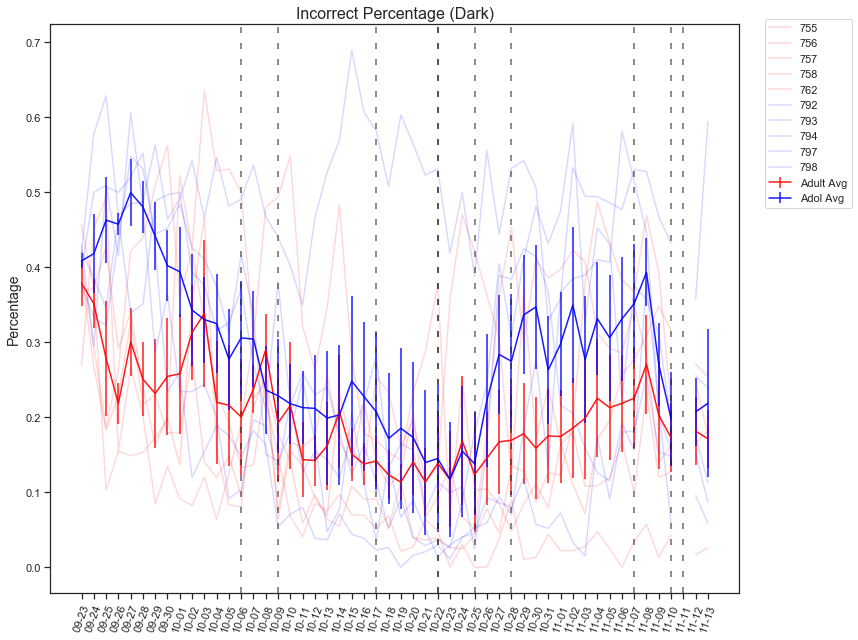

In [80]:
plot_metrics(total_incorrect_pct_pivot, percentage=True, paradigms=dates_tir, save_fig=True)


[Matplotlib Linestyles - Docs](https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/linestyles.html) (Dashed Lines etc.)  

[Plotting Multiple Vertical Lines (for datetime)](https://stackoverflow.com/questions/19213789/how-do-you-plot-a-vertical-line-on-a-time-series-plot-in-pandas/35902487)

### Formatters and Converters Issue (Matplotlib vs. Pandas)
- unrelated to plotting since it's a warning that goes away after one iteration, BUT, leaving it here as documentation in case it's raised again and I need to troubleshoot it. 

[Explanation of the Warning](https://github.com/facebook/prophet/issues/999)  

[Another Explanation of Pandas - Matplotlib Converters](https://nextjournal.com/blog/plotting-pandas-prophet)

[Matplotlib Converters Documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.register_matplotlib_converters.html)


In conclusion, just follow the warning sign and add/change as necessary! 

____

### Date Formatter!! 

[How to format dates x-axis ticks - StackOverflow](https://stackoverflow.com/questions/14946371/editing-the-date-formatting-of-x-axis-tick-labels-in-matplotlib) (Using DateFormatter)  

[Example of plt.xticks(location, labels, rotation)](https://stackoverflow.com/questions/32572419/matplotlib-not-showing-all-x-axis-data-frame-variable) (As used above in the graph)


____
### Other IMPT References

#### Different Error Types - Important!! 
1. [ValueError vs. TypeError](https://stackoverflow.com/questions/48343387/valueerror-and-typeerror-in-python)


#### Type() vs isinstance()! Also Important!! 
1. [type() vs. isinstance()](https://stackoverflow.com/questions/1549801/what-are-the-differences-between-type-and-isinstance)

#### Checking if all items in a list are string types
1. [How to check if all items in list are strings](https://stackoverflow.com/questions/37357798/how-to-check-if-all-items-in-list-are-string)

2. [Check if objects is a list of strings - using basestring](https://stackoverflow.com/questions/18495098/python-check-if-an-object-is-a-list-of-strings)*

*Oops Nevermind! Basestring removed from Python 3*:
[Python Docs](https://docs.python.org/3.0/whatsnew/3.0.html#text-vs-data-instead-of-unicode-vs-8-bit)
